# Covid 19 Ratio of Deaths to Cases from 28 Days Earlier
## Summary
I realised a while back that I was trying to do two things 'by eye';
1. understand the time-lag between cases being recorded and deaths being registered
2. understand how the UK's vaccination programme is impacting the ratio of deaths to the number of positive cases

So this analysis attempts to formalise both of those two 'eyeball' comparisons.
It starts with two pieces of data;
1. New cases recorded, by the 'specimen date' (the date on which the specimen was taken for analysis)
2. New deaths 'within 28 days of a positive test' by date

It then performs two computations;
1. Computes the time lag between cases and deaths (as defined above)
2. Using that lag, computes the ratio 
$$
{deaths} \over {cases_{lagged}}
$$

From this analysis, it does look (to me!) as though the vaccination programme is indeed having an ongoing impact the reduces that ratio.

## The impact of the level of testing
It's worth noting that **this analysis does not take any account of the number of tests being performed**.
The reason this matters is that - all thing being equal - 
* if you test more, then you find more cases.
* it is reasonable to make an assumption that almost everyone who *actually* dies of Covid-19 will get a test at some point, so the number of deaths attributed to Covid-19 will not change significantly

This means that *more testing will cause the proportion of deaths:cases to go down*.

From a quick review of the [UK Government data on testing](https://coronavirus.data.gov.uk/details/testing) my own opinion is that;
* This *is* significant during 2020, especially early on, when testing was only done using the PCR test in hospitals
    * *it is my opinion think that reducing ratios of deaths to cases during 2020 is down to many factors including more testing and continuously improving treatment approaches*
* This *is not* significant during 2021: although the level of testing varies from week to week, it is neither trending up nor trending down significantly


## Disclaimer
I am not a epidemeologist, so this analysis is purely based on what can be inferred from the available information. 
One way of saying this is that it formalises my intuitions into precise operations on the data.
If those intuitions are wrong, then so is this analysis.

# Computation
## Install packages
This assumes that the user has at least;
* python
* pip
* jupyter

For a fresh install, change
``` python
install=False
```
to
``` python
install=True
```

In [8]:
# Install a pip package in the current Jupyter kernel
import sys

install=False
if install:
    run_python = sys.executable
    print(f"Python executable: {run_python}")
    # Upgrade pip
    !{run_python} -m pip install --upgrade pip

    # Install all the necessary modules (guarantees this should work!)
    !{run_python} -m pip install uk_covid19
    !{run_python} -m pip install pandas
    !{run_python} -m pip install matplotlib
    
else:
    print("Proceeding without installation. Modify the line above;\n    install=False\nto;\n    install=True\n...to install all of the required packages")
    
    


Proceeding without installation. Modify the line above;
    install=False
to;
    install=True
...to install all of the required packages


## Import data and set date as index

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# This is the data.gov SDK for interacting with covid data
from uk_covid19 import Cov19API

# Choose England only
england_only = [
        'areaType=nation',
        'areaName=England'
    ]

# Define fields to retrieve
cases_and_deaths = {
        "date": "date",
        "areaName": "areaName",
        "areaCode": "areaCode",
        "Cases": "newCasesBySpecimenDate",
        "Deaths": "newDeaths28DaysByDeathDate"
    }
api = Cov19API(filters=england_only, structure=cases_and_deaths)
data = api.get_dataframe()
data = data.fillna(0)


# Set key to be the date
data=data.set_index('date', drop=False)

# Set the Date column to be a proper datetime (helps get the axes sensible)
data['Date'] = pd.to_datetime(data['date'])

# Step 1: Find the optimum 'offset' for cases vs deaths
## Background
There is clearly a 'lag' between a positive test data and the death data. Deaths are defined to be 'deaths within 28 days of a positive test', so the offset certainly cannot be more than 28 - but what is the value for the offset that correlates best? This computation works by;
1. Taking the death data unshifted from a specific start date to the end of the dataset
2. Taking case data from the same start date, but clipped to be 28 days shorter.
3. Computing the correlation between deaths and the 'clipped' cases for every full overlap - ie from an offset of zero days to an offset of 28 days

## Choice of date range to compute correlation
I've chosen from the beginning of June 2020. This is a somewhat arbitrary date, but was chosen to avoid the first few months of the pandemic because
* treatments were still being tested and were changing frequently
* testing rates were very low and changing very fast

Each of these two would mess up any kind of stable relationship between cases and death rates. Since the main aim of this analysis is to pick out the impact of vaccination on the cases:deaths ratio, I've chosen to choose a date that *attempts to* remove very large known other factors that might impact the correlation offset.

Maximum correlation offset: 14 days
Hard coding offset to : 14 days


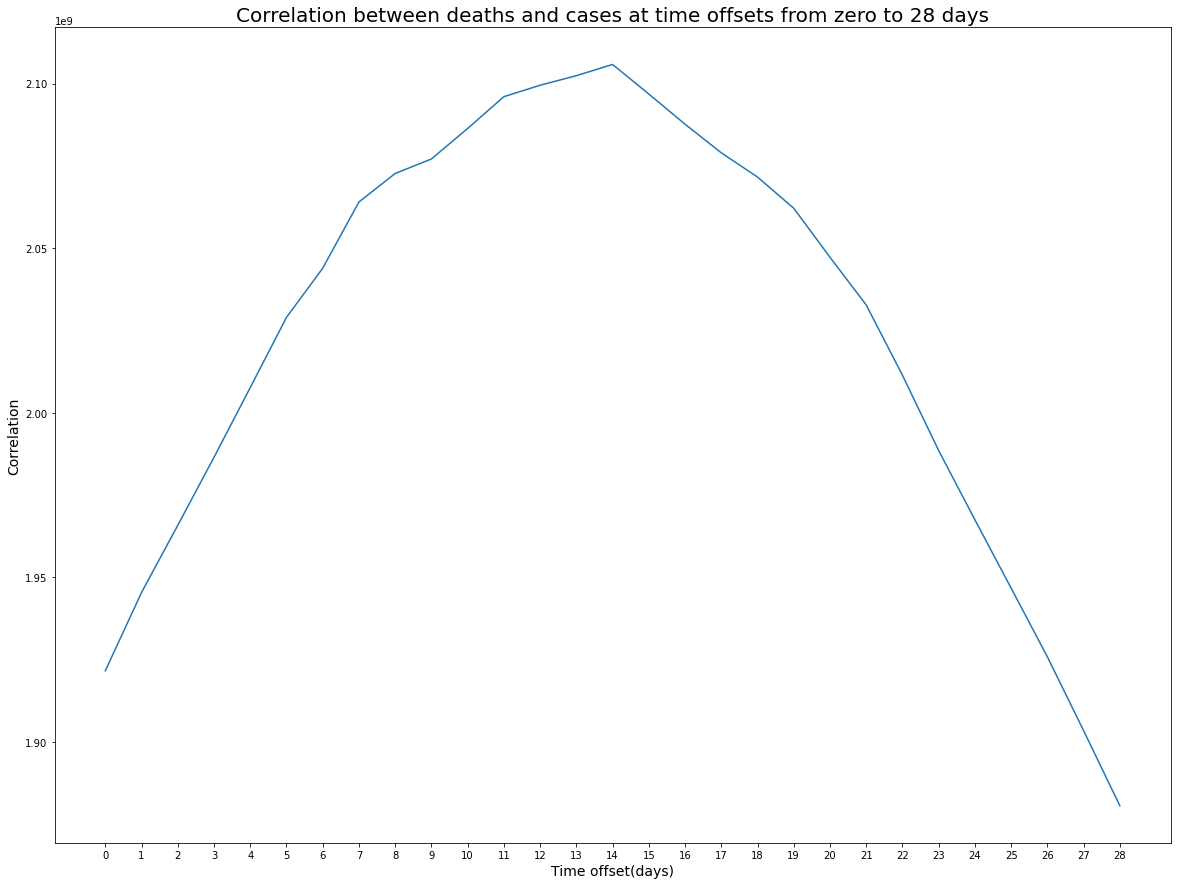

In [10]:
# Set the starting date to consider for correlation
correl_start_date = '2020-06-01'

# Find the last date in the dataset
max_date = data['Date'].max()

# compute the date 28 days earlier
max_date_28 = max_date - datetime.timedelta(days=28)

# Convert deaths data to numpy for correlation
deaths_data = data.loc[(data.Date>correl_start_date), 'Deaths'].to_numpy()

# Clip 28 days off the end of the cases data 
cases_data = data.loc[(data.Date>correl_start_date) & (data.Date<=max_date_28), 'Cases'].to_numpy()

# This effectively shifts the cases data across the deaths data for zero to 28 days offset,
# computing the correlation at each offset
cross_corr = np.correlate(deaths_data, cases_data, "valid")

# Find the offset that gives maximum correlation
offset_max_correlation = cross_corr.argmax()
print(f"Maximum correlation offset: {offset_max_correlation} days")
offset_max_correlation = 14
print(f"Hard coding offset to : {offset_max_correlation} days")


corr_offsets = np.arange(0,29)
fig, ax = plt.subplots(figsize=(20,15))
ax.set_xticks(np.arange(0,29))
ax.set_title("Correlation between deaths and cases at time offsets from zero to 28 days", fontsize=20)
ax.set_xlabel("Time offset(days)", fontsize=14)
ax.set_ylabel("Correlation", fontsize=14)
ax.plot(corr_offsets, cross_corr)
fig.savefig("covid-offset-correlation.png")

# Step 2: Compute the ratio of (lagged) cases to deaths
## The period chosen
I chose not to show the very beginning of the pandemic (Feb 2020 - May 2020) in the graphs, because 
* the very early data is very noisy, and data collection approaches were changing
* the ratio of deaths to cases is very high indeed, such that it swamps the visualization

If you want to show a different start date, you'll need to modify
``` python
graph_start_date = '2020-06-01'
```
to whatever you prefer.

## Define earlier cases function

In [11]:
# This function returns a function that finds the cases the specified offset earlier
def cases_earlier_by(offset_days):
    
    def cases_earlier_than(date_string):
        date = pd.to_datetime(date_string)
        earlier_date = date - datetime.timedelta(days=int(offset_days))
        if (earlier_date < pd.to_datetime('2020-01-30')):
            return 0
        else:
            earlier_date_key = earlier_date.strftime("%Y-%m-%d")
            return data.loc[earlier_date_key, 'Cases']
    
    return cases_earlier_than

# Define the offset to be 14 days. 'By eye' this appears to be about the right lag
cases_earlier = cases_earlier_by(offset_max_correlation)
cases_earlier_name = f'Daily Cases {offset_max_correlation} Days Earlier'
mean_cases_earlier_name = f'Mean {cases_earlier_name}'



## Rolling averages and ratios

In [12]:
# Add earlier cases to each row
data[cases_earlier_name] = data['date'].apply(cases_earlier)

# Define the rolling average window to be 7 days
window = 7

# Define rolling averages
data['Mean Daily Deaths'] = data['Deaths'].rolling(window).mean()
data[mean_cases_earlier_name] = data[cases_earlier_name].rolling(window).mean()

# Define ratios
data['Noisy Ratio'] = data['Deaths']/data[cases_earlier_name]
data['Ratio'] = data['Mean Daily Deaths']/data[mean_cases_earlier_name]
data['Smooth Ratio'] = data['Ratio'].rolling(2*window).mean()
data['Date+7'] = data['Date']+datetime.timedelta(days=14)


## Graphs

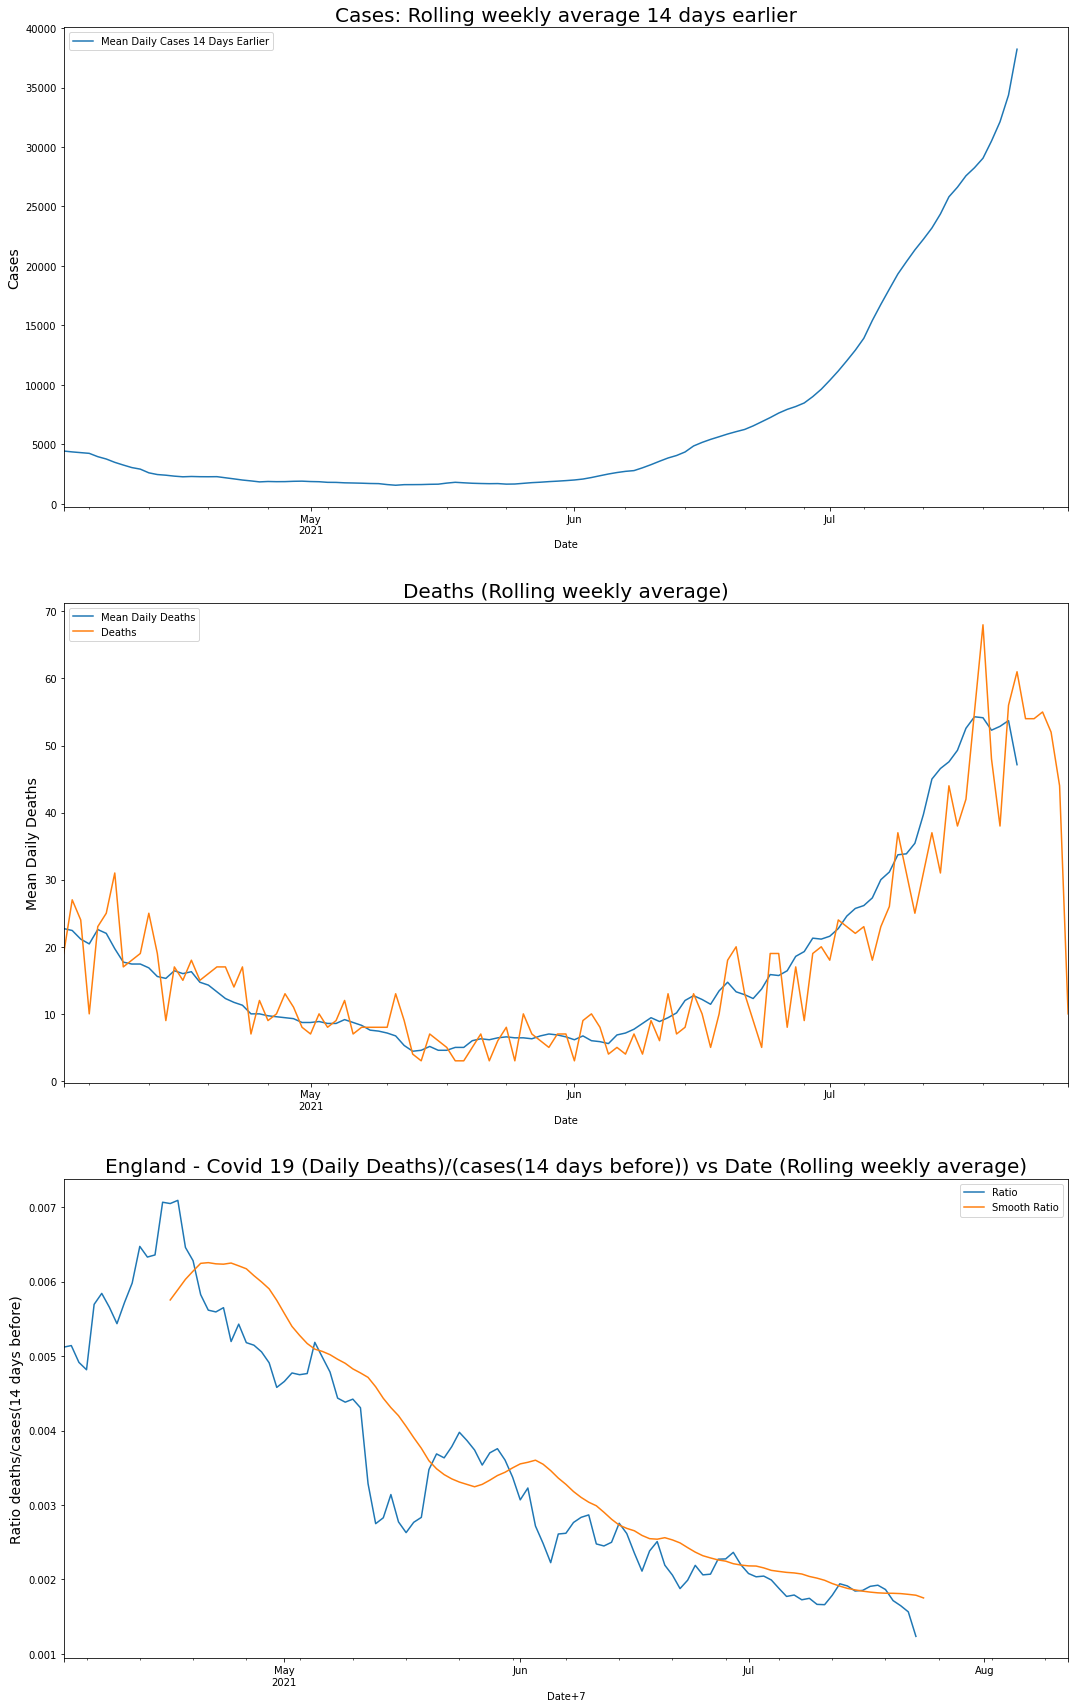

In [13]:
# set the graphing start date
graph_start_date = '2021-04-01'

fig, axs = plt.subplots(3,1, figsize=(18, 30))        # Create an empty matplotlib Figure and Axes

ax_cases = axs[0]
ax_deaths = axs[1]
ax_ratio = axs[2]

ax_ratio.set_ylabel(f"Ratio deaths/cases({offset_max_correlation} days before)", fontsize=14)          # Do any matplotlib customization you like
ax_ratio.set_title(f"England - Covid 19 (Daily Deaths)/(cases({offset_max_correlation} days before)) vs Date (Rolling weekly average)", fontsize=20)
data[data['Date']>graph_start_date].plot(ax=ax_ratio, x='Date', y=['Ratio'])
data[data['Date']>graph_start_date].plot(ax=ax_ratio, x='Date+7', y=['Smooth Ratio'])

ax_deaths.set_ylabel("Mean Daily Deaths", fontsize=14)          # Do any matplotlib customization you like
ax_deaths.set_title("Deaths (Rolling weekly average)", fontsize=20)
data[data['Date']>graph_start_date].plot(ax=ax_deaths, x='Date', y=['Mean Daily Deaths', 'Deaths'])

ax_cases.set_ylabel('Cases', fontsize=14)
ax_cases.set_title(f'Cases: Rolling weekly average {offset_max_correlation} days earlier', fontsize=20)
data[data['Date']>graph_start_date].plot(ax=ax_cases, x='Date', y=[mean_cases_earlier_name])


fig.savefig("covid-ratio.png")